## Algoritms #8

## Снижение размерности данных

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

1. Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd()
2. Обучить любую модель классификации на датасете IRIS до применения PCA и после него. Сравнить качество классификации по отложенной выборке.

In [8]:
# Загрузим игрушечный датасет из sklearn
iris = datasets.load_iris()
X = iris.data
y = iris.target
X.shape

(150, 4)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [48]:
""" Блок функционала PCA """

# Центрирование данных около нуля

def get_scaled_data(X):

    # Для начала отмасштабируем выборку
    X_ = X.astype(float)

    rows, cols = X_.shape

    # центрирование - вычитание из каждого значения среднего по строке
    means = X_.mean(0)
    for i in range(rows):
        for j in range(cols):
            X_[i, j] -= means[j]

    # деление каждого значения на стандартное отклонение
    std = np.std(X_, axis=0)
    for i in range(cols):
        for j in range(rows):
            X_[j][i] /= std[i]
    
    return X_


# Расчет собственных векторов и собственных значений

def get_eigen_val(X_, show_info):


    covariance_matrix = X_.T.dot(X_)

    eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

    # сформируем список кортежей (собственное значение, собственный вектор)
    eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

    # и отсортируем список по убыванию собственных значений
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    
    
    if show_info == True:
        print('Собственные значения в порядке убывания:')
        for i in eig_pairs:
            print(i)
        
    return eig_values, eig_pairs


def eig_info(eig_values):
    eig_sum = sum(eig_values)
    var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    print(f'\nДоля дисперсии, описываемая каждой из компонент \n{var_exp}\n')

    # а теперя оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
    print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}\n')
    
    
    
def refactor_matrix(X, factor, show_info=True):  

    X_ = get_scaled_data(X)
      
    if show_info == True:
        print('='*25, 'PCA преобразование матрицы с итоговым количеством признаков: ', factor, '='*25,'\n')
        eig_values, eig_pairs = get_eigen_val(X_, show_info)
        eig_info(eig_values)
    else:
        eig_values, eig_pairs = get_eigen_val(X_, show_info)
         
    # Формирование вектора весов из собственных векторов, в соответствии с заданным кол-вом главных компонент
    
    if factor == 1:
        W = eig_pairs[0][1].reshape(4,1)
    if factor == 2:
        W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
    if factor == 3:
        W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1), eig_pairs[2][1].reshape(4,1)))

    # Сформируем новую матрицу "объекты-признаки"
    Z = X_.dot(W)
    
    if show_info == True:
        print(f'Матрица весов W:\n', W)
        print('\n','='*115)
    
    return Z

In [49]:
""" Реализация работы алгоритма PCA """

factor = 2 # Количество признаков после обработки PCA
Z = refactor_matrix(X, factor)

========================= PCA преобразование матрицы с итоговым количеством признаков:  2 ========================= 

Собственные значения в порядке убывания:
(437.7746724797988, array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654]))
(137.10457072021055, array([-0.37741762, -0.92329566, -0.02449161, -0.06694199]))
(22.013531335697195, array([-0.71956635,  0.24438178,  0.14212637,  0.63427274]))
(3.107225464292886, array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))

Доля дисперсии, описываемая каждой из компонент 
[72.96244541329987, 22.850761786701778, 3.6689218892828697, 0.5178709107154814]

Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]



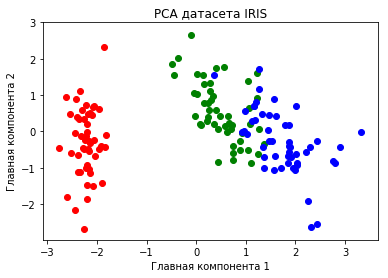

In [50]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(Z[y==i, 0], Z[y==i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

In [51]:
""" Блок функционала кластеризации методом KNN """

# Подсчет Евклидовой метрики

def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)


# Подсчет точности работы алгоритма

def accuracy(pred, y):
    return (sum(pred == y) / len(y))


# Реализация KNN

def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1 / (d[0] + 1 ) ** 2
            
        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

In [54]:
""" Классификация KNN на исходных данных """

k = 10

y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма на исходных данных при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма на исходных данных при k = 10: 0.974


In [55]:
""" Классификация KNN на данных пониженной размерности """

factor = np.arange(1,4) # Количество признаков после обработки PCA

for f in factor:
    X_train_scaled = refactor_matrix(X_train, f, show_info=False)
    X_test_scaled = refactor_matrix(X_test, f, show_info=False)

    y_pred = knn(X_train_scaled, y_train, X_test_scaled, k)

    print(f'Точность алгоритма после PCA при k = {k}, снижение размерности признаков до {f}-мерного: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма после PCA при k = 10, снижение размерности признаков до 1-мерного: 0.974
Точность алгоритма после PCA при k = 10, снижение размерности признаков до 2-мерного: 0.974
Точность алгоритма после PCA при k = 10, снижение размерности признаков до 3-мерного: 0.947


In [56]:
""" Реализация PCA с помощью SVD разложения """

def refactor_matrix_svd(X, factor, show_info=True):
    
    X_ = get_scaled_data(X)  
    U,s,V = np.linalg.svd(X_, full_matrices=False)  
    # Z = np.dot(U[:,:factor],np.dot(np.diag(s[:factor]),V[:factor,:])) # X(d) = U D V.T
    W = V[:,:factor]
    Z = np.dot(X_, W)

    return Z

In [57]:
""" Реализация работы алгоритма PCA """

factor = 2 # Количество признаков после обработки PCA
Z = refactor_matrix_svd(X, factor)

In [58]:
""" Классификация KNN для обработанных SVD данных """

factor = np.arange(1,4) # Количество признаков после обработки PCA

for f in factor:
    X_train_scaled = refactor_matrix_svd(X_train, f, show_info=False)
    X_test_scaled = refactor_matrix_svd(X_test, f, show_info=False)

    y_pred = knn(X_train_scaled, y_train, X_test_scaled, k)

    print(f'Точность алгоритма после PCA, SVD при k = {k}, снижение размерности признаков до {f}-мерного: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма после PCA, SVD при k = 10, снижение размерности признаков до 1-мерного: 0.711
Точность алгоритма после PCA, SVD при k = 10, снижение размерности признаков до 2-мерного: 0.553
Точность алгоритма после PCA, SVD при k = 10, снижение размерности признаков до 3-мерного: 0.737
